In [30]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [31]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('/content/DELL.csv')
df1=df.reset_index()['Close']

In [32]:
# 3. Scale data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [45]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [46]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [47]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [48]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [49]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [50]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 2s 49ms/step - loss: 0.0080 - val_loss: 0.0316
Epoch 2/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0024 - val_loss: 0.0110
Epoch 3/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 4/100
12/12 [==============================] - 0s 34ms/step - loss: 8.0112e-04 - val_loss: 0.0051
Epoch 5/100
12/12 [==============================] - 1s 52ms/step - loss: 6.7790e-04 - val_loss: 0.0045
Epoch 6/100
12/12 [==============================] - 1s 48ms/step - loss: 6.2851e-04 - val_loss: 0.0033
Epoch 7/100
12/12 [==============================] - 1s 48ms/step - loss: 5.8189e-04 - val_loss: 0.0029
Epoch 8/100
12/12 [==============================] - 1s 51ms/step - loss: 5.5520e-04 - val_loss: 0.0032
Epoch 9/100
12/12 [==============================] - 1s 44ms/step - loss: 5.3069e-04 - val_loss: 0.0022
Epoch 10/100
12/12 [==============================] - 0s 27ms/step - loss: 5

In [51]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 25ms/step


In [52]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [53]:
# 12. Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 44.264335543030676
Testing RMSE: 48.116448339023265
Validation MAE: 44.22930832670992
Testing MAE: 47.59206226160513
Validation MAPE: 66.36877928008795
Testing MAPE: 67.51448527165006


In [54]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=80
i=0
while(i<30):

    if(len(temp_input)>80):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.7253781]
81
1 day input [0.59078804 0.58905413 0.59382245 0.58471926 0.57149788 0.56369508
 0.55936021 0.55350811 0.54527192 0.52966636 0.50647479 0.52316405
 0.5021399  0.47873163 0.47548046 0.49672131 0.49585431 0.50755849
 0.48956881 0.51839567 0.53140035 0.50820879 0.50257341 0.49303671
 0.50625809 0.51319387 0.53075006 0.54678913 0.55437511 0.57084767
 0.56868019 0.56716298 0.55480862 0.58081785 0.58450245 0.59035455
 0.60726062 0.6209154  0.63500376 0.6690325  0.63283636 0.61311261
 0.6172308  0.6079108  0.58688665 0.58601966 0.61051171 0.62546708
 0.63261958 0.65299343 0.66166322 0.64042235 0.6666483  0.68030317
 0.6794362  0.67618509 0.65169304 0.65299343 0.65667812 0.6664316
 0.67661849 0.70414495 0.71779982 0.71324822 0.68745567 0.67791899
 0.7249524  0.73427229 0.70847984 0.65407722 0.66816551 0.70739612
 0.66859902 0.69829285 0.71584912 0.7208342  0.71476543 0.72473561
 0.74055787 0.7253781 ]
1 day output [[0.7174138]]
2 day input [0.58905413 0.59382245 0.58471926 0.5714

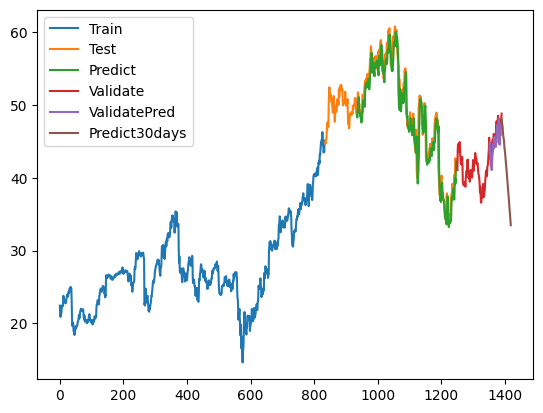

In [55]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')